In [243]:
import random
import numpy as np
import os
import pandas as pd
from tqdm import tqdm 
import matplotlib.pyplot as plt
from collections import defaultdict

In [244]:
# red convolucional para clasificar equipos en base a un ranking

# equipos en posiciones 1 a 4 -> 1 
# equipos en posiciones 5 a 8 -> 2
# equipos en posiciones 9 a 12 -> 3
# equipos en posiciones 13 a 16 -> 4
# equipos en posiciones 17 a 20 -> 5

# el input son 5 matrices y el numero en la tabla de posiciones:
# [matriz 1, matriz 2, matriz 3, matriz 4, matriz 5, posicion]

In [245]:
def get_initial_11(team):
    base_path = '/Users/luisalawson/Desktop/SoccerDefenseAnalysis/src/data'
    team_data_path = os.path.join(base_path, team, f'{team}_summary.csv')
    try:
        df = pd.read_csv(team_data_path)
        df = df.drop_duplicates()
        df = df.sort_values(by='MinutesPlayed', ascending=False)
        return df['PlayerName'][:11].tolist()
    except FileNotFoundError:
        print(f'Error: El archivo {team}_summary.csv no se encontró en la carpeta de {team}.')
        return None
    except Exception as e:
        print(f'Error al cargar el archivo para {team}: {str(e)}')
        return None

In [246]:
def get_team_players(team):
    base_path = '/Users/luisalawson/Desktop/SoccerDefenseAnalysis/src/data'
    team_data_path = os.path.join(base_path, team, f'{team}_summary.csv')
    try:
        df = pd.read_csv(team_data_path)
        df = df.drop_duplicates()
        df = df.sort_values(by='MinutesPlayed', ascending=False)
        return df['PlayerName'].tolist()
    except FileNotFoundError:
        print(f'Error: El archivo {team}_summary.csv no se encontró en la carpeta de {team}.')
        return None
    except Exception as e:
        print(f'Error al cargar el archivo para {team}: {str(e)}')
        return None

In [247]:
def load_player_matrix(team_name, player_name, matrix_name):
    base_path = '/Users/luisalawson/Desktop/SoccerDefenseAnalysis/src/data'  
    if matrix_name != 'pass_transition_matrix':
        matrix_path = os.path.join(base_path, team_name, player_name, f'{matrix_name}.csv')
        matrix = np.loadtxt(matrix_path, delimiter=',')
    else:
        matrix_path = os.path.join(base_path, team_name, player_name, f'{matrix_name}.npy')
        matrix = np.load(matrix_path)
    return matrix

In [248]:
def aggregate_team_matrices(team, players):
    team_matrixes = {
        'pass_matrix':  np.zeros((10, 10)),
        'shot_matrix': np.zeros((10, 10)),
        'defense_matrix': np.zeros((10, 10)),
        'goal_matrix': np.zeros((10, 10)),
        'errors_matrix': np.zeros((10, 10)),
        'out_matrix': np.zeros((10, 10)),
        'goalkeeper_matrix': np.zeros((10,10))
    }

    for player in players:
        team_matrixes['pass_matrix'] += load_player_matrix(team, player, 'pass_matrix')
        team_matrixes['shot_matrix'] += load_player_matrix(team, player, 'shot_matrix')
        team_matrixes['defense_matrix'] += load_player_matrix(team, player, 'defense_matrix')
        team_matrixes['goal_matrix'] += load_player_matrix(team, player, 'goal_matrix')
        team_matrixes['errors_matrix'] += load_player_matrix(team, player, 'errors_matrix')
        team_matrixes['out_matrix'] += load_player_matrix(team, player, 'out_matrix') 
    
    return team_matrixes

In [249]:
df = pd.read_csv('/Users/luisalawson/Downloads/Sample Data/epl.csv', delimiter = ';')

In [250]:
teams_list = df['home_team_name'].unique()

In [251]:
teams_list

array(['Arsenal', 'Everton', 'Fulham', 'Manchester City',
       'Newcastle United', 'Queens Park Rangers', 'Reading',
       'West Bromwich Albion', 'West Ham United', 'Wigan Athletic',
       'Aston Villa', 'Chelsea', 'Liverpool', 'Manchester United',
       'Norwich City', 'Southampton', 'Stoke City', 'Sunderland',
       'Swansea City', 'Tottenham Hotspur'], dtype=object)

In [252]:
team_matrixes = {}

for team in teams_list:
    players = get_team_players(team) 
    team_matrixes[f'{team}'] = aggregate_team_matrices(team, players) 

In [253]:
for team in teams_list:
    for matrix in team_matrixes[f'{team}']:
        team_matrixes[f'{team}'][matrix] = np.sum(team_matrixes[f'{team}'][matrix] * 90)

In [254]:
team_matrixes

{'Arsenal': {'pass_matrix': np.float64(949.60908),
  'shot_matrix': np.float64(30.005369999999996),
  'defense_matrix': np.float64(228.83508),
  'goal_matrix': np.float64(3.03336),
  'errors_matrix': np.float64(93.90699),
  'out_matrix': np.float64(55.00818000000001),
  'goalkeeper_matrix': np.float64(0.0)},
 'Everton': {'pass_matrix': np.float64(603.3320999999999),
  'shot_matrix': np.float64(34.141769999999994),
  'defense_matrix': np.float64(192.26763000000003),
  'goal_matrix': np.float64(2.03121),
  'errors_matrix': np.float64(103.28607),
  'out_matrix': np.float64(57.66281999999999),
  'goalkeeper_matrix': np.float64(0.0)},
 'Fulham': {'pass_matrix': np.float64(952.1227799999999),
  'shot_matrix': np.float64(58.831019999999995),
  'defense_matrix': np.float64(319.5000899999999),
  'goal_matrix': np.float64(2.28771),
  'errors_matrix': np.float64(120.0726),
  'out_matrix': np.float64(70.83467999999999),
  'goalkeeper_matrix': np.float64(0.0)},
 'Manchester City': {'pass_matrix': n

In [255]:
import numpy as np

# Convertir los datos en una matriz de características
teams = list(team_matrixes.keys())
features = ['pass_matrix', 'shot_matrix', 'defense_matrix', 'goal_matrix', 'errors_matrix', 'out_matrix', 'goalkeeper_matrix']
X = np.array([[team_matrixes[team][feature] for feature in features] for team in teams])

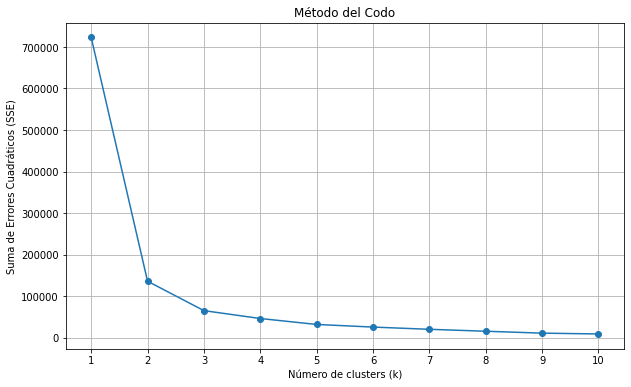

In [256]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Rango de valores para k
k_values = range(1, 11)  # Probar con 1 a 10 clusters
sse = []

# Calcular SSE para cada k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

# Graficar el resultado
plt.figure(figsize=(10, 6))
plt.plot(k_values, sse, marker='o')
plt.title('Método del Codo')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Suma de Errores Cuadráticos (SSE)')
plt.xticks(k_values)
plt.grid()
plt.show()

In [266]:
from sklearn.cluster import KMeans

n_clusters = 2

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(X)

team_clusters = {team: cluster for team, cluster in zip(teams, clusters)}
print(team_clusters)


{'Arsenal': np.int32(1), 'Everton': np.int32(0), 'Fulham': np.int32(1), 'Manchester City': np.int32(1), 'Newcastle United': np.int32(0), 'Queens Park Rangers': np.int32(0), 'Reading': np.int32(0), 'West Bromwich Albion': np.int32(0), 'West Ham United': np.int32(0), 'Wigan Athletic': np.int32(1), 'Aston Villa': np.int32(0), 'Chelsea': np.int32(1), 'Liverpool': np.int32(1), 'Manchester United': np.int32(1), 'Norwich City': np.int32(0), 'Southampton': np.int32(0), 'Stoke City': np.int32(0), 'Sunderland': np.int32(0), 'Swansea City': np.int32(1), 'Tottenham Hotspur': np.int32(1)}


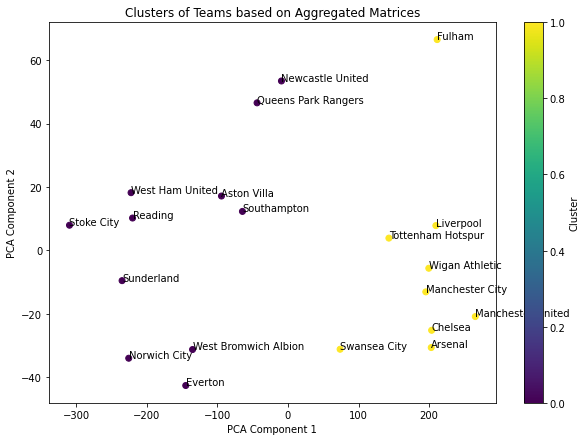

In [267]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reducir la dimensionalidad a 2 componentes principales para visualización
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

# Graficar los clusters
plt.figure(figsize=(10, 7))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=clusters, cmap='viridis')
for i, team in enumerate(teams):
    plt.text(X_reduced[i, 0], X_reduced[i, 1], team)

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Clusters of Teams based on Aggregated Matrices')
plt.colorbar(label='Cluster')
plt.show()

In [268]:
def remove_player_from_team(team, player):
    # Aquí debes implementar la lógica para ajustar las matrices
    # por ejemplo, restar la contribución del jugador de cada matriz
    for matrix in team_matrixes[team]:
        team_matrixes[team][matrix] -= load_player_matrix(team, player, matrix)

In [269]:
# Ejemplo de jugador a remover
team = 'Manchester United'
player = 'van Persie, Robin'  # Cambia esto al nombre del jugador que quieres remover

remove_player_from_team(team, player)

In [270]:
team_matrixes

{'Arsenal': {'pass_matrix': np.float64(949.60908),
  'shot_matrix': np.float64(30.005369999999996),
  'defense_matrix': np.float64(228.83508),
  'goal_matrix': np.float64(3.03336),
  'errors_matrix': np.float64(93.90699),
  'out_matrix': np.float64(55.00818000000001),
  'goalkeeper_matrix': np.float64(0.0)},
 'Everton': {'pass_matrix': np.float64(603.3320999999999),
  'shot_matrix': np.float64(34.141769999999994),
  'defense_matrix': np.float64(192.26763000000003),
  'goal_matrix': np.float64(2.03121),
  'errors_matrix': np.float64(103.28607),
  'out_matrix': np.float64(57.66281999999999),
  'goalkeeper_matrix': np.float64(0.0)},
 'Fulham': {'pass_matrix': np.float64(952.1227799999999),
  'shot_matrix': np.float64(58.831019999999995),
  'defense_matrix': np.float64(319.5000899999999),
  'goal_matrix': np.float64(2.28771),
  'errors_matrix': np.float64(120.0726),
  'out_matrix': np.float64(70.83467999999999),
  'goalkeeper_matrix': np.float64(0.0)},
 'Manchester City': {'pass_matrix': n

In [262]:
X_new = np.array([[team_matrixes[team][feature] for feature in features] for team in teams])

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (20, 7) + inhomogeneous part.

In [240]:
# Ejecutar KMeans para el equipo modificado
kmeans_new = KMeans(n_clusters=n_clusters, random_state=42)
clusters_new = kmeans_new.fit_predict(X_new)

# Crear un diccionario con los clusters
team_clusters_new = {team: cluster for team, cluster in zip(teams, clusters_new)}

# Imprimir el cluster del equipo modificado
print(f'Cluster del equipo {team} sin {player}: {team_clusters_new[team]}')

NameError: name 'X_new' is not defined

In [271]:
import pandas as pd

# Cargar los datos desde el archivo Excel
ranking_data = pd.read_excel('/Users/luisalawson/Desktop/Ranking.xlsx')  # Asegúrate de cambiar la ruta

In [272]:
# Convertir team_clusters a DataFrame
clusters_df = pd.DataFrame(list(team_clusters.items()), columns=['Equipo', 'Cluster'])

# Unir los datos de ranking con los clusters
merged_data = pd.merge(ranking_data, clusters_df, on='Equipo', how='left')


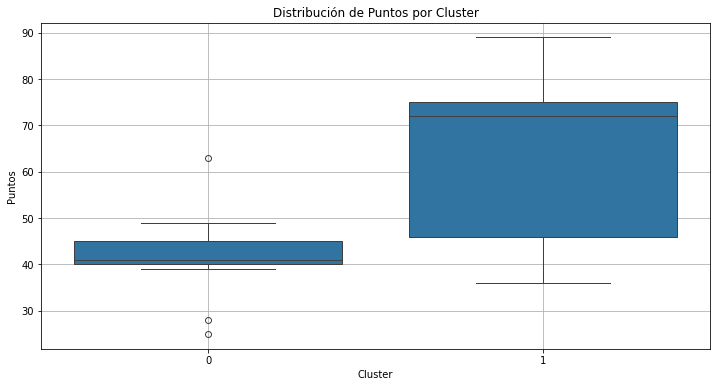

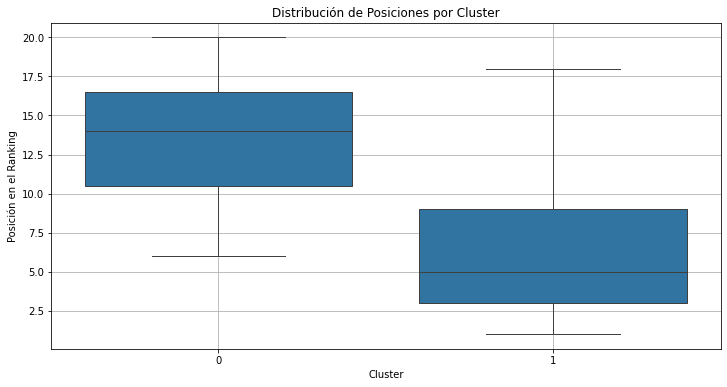

In [273]:
import matplotlib.pyplot as plt
import seaborn as sns

# Graficar la distribución de puntos por cluster
plt.figure(figsize=(12, 6))
sns.boxplot(x='Cluster', y='Puntos', data=merged_data)
plt.title('Distribución de Puntos por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Puntos')
plt.grid()
plt.show()

# Graficar la distribución de posiciones por cluster
plt.figure(figsize=(12, 6))
sns.boxplot(x='Cluster', y='Posicion', data=merged_data)
plt.title('Distribución de Posiciones por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Posición en el Ranking')
plt.grid()
plt.show()


## Clusters con matrices

In [274]:
team_matrixes = {}

for team in teams_list:
    players = get_team_players(team) 
    team_matrixes[f'{team}'] = aggregate_team_matrices(team, players) 

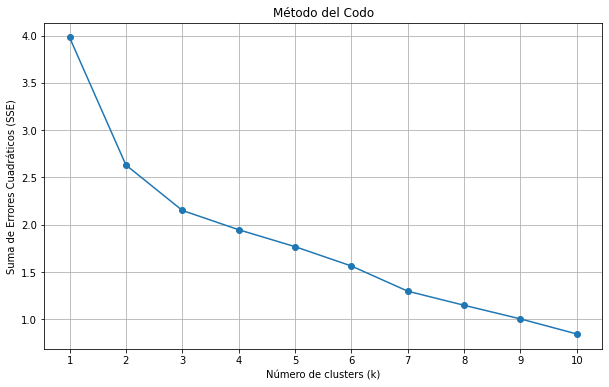

In [281]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Rango de valores para k
k_values = range(1, 11)  # Probar con 1 a 10 clusters
sse = []

# Calcular SSE para cada k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

# Graficar el resultado
plt.figure(figsize=(10, 6))
plt.plot(k_values, sse, marker='o')
plt.title('Método del Codo')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Suma de Errores Cuadráticos (SSE)')
plt.xticks(k_values)
plt.grid()
plt.show()

{'Arsenal': np.int32(4), 'Everton': np.int32(0), 'Fulham': np.int32(2), 'Manchester City': np.int32(4), 'Newcastle United': np.int32(5), 'Queens Park Rangers': np.int32(5), 'Reading': np.int32(0), 'West Bromwich Albion': np.int32(0), 'West Ham United': np.int32(0), 'Wigan Athletic': np.int32(1), 'Aston Villa': np.int32(0), 'Chelsea': np.int32(6), 'Liverpool': np.int32(1), 'Manchester United': np.int32(1), 'Norwich City': np.int32(0), 'Southampton': np.int32(0), 'Stoke City': np.int32(0), 'Sunderland': np.int32(0), 'Swansea City': np.int32(3), 'Tottenham Hotspur': np.int32(1)}


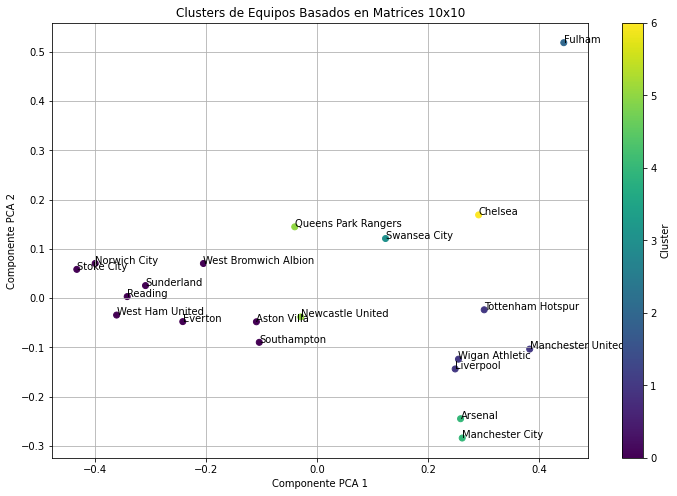

In [282]:
import numpy as np

# Convertir las matrices 10x10 en una matriz de características
teams = list(team_matrixes.keys())
features = ['pass_matrix', 'shot_matrix', 'defense_matrix', 'goal_matrix', 'errors_matrix', 'out_matrix']

# Inicializar la matriz de características
X = []

for team in teams:
    team_vector = []
    for feature in features:
        # Obtener la matriz 10x10 y aplanarla a un vector de 100 elementos
        team_vector.extend(team_matrixes[team][feature].flatten())  # Aplanar la matriz 10x10
    X.append(team_vector)

X = np.array(X)  # Convertir a un array numpy

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Definir el número de clusters
n_clusters = 7  # Ajusta según sea necesario

# Crear y ajustar el modelo KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(X)

# Asignar cada equipo a su cluster
team_clusters = {team: cluster for team, cluster in zip(teams, clusters)}
print(team_clusters)
from sklearn.decomposition import PCA

# Reducir la dimensionalidad a 2 componentes principales para visualización
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

# Graficar los clusters
plt.figure(figsize=(12, 8))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=clusters, cmap='viridis')
for i, team in enumerate(teams):
    plt.text(X_reduced[i, 0], X_reduced[i, 1], team)

plt.title('Clusters de Equipos Basados en Matrices 10x10')
plt.xlabel('Componente PCA 1')
plt.ylabel('Componente PCA 2')
plt.colorbar(label='Cluster')
plt.grid()
plt.show()

In [283]:
# Convertir team_clusters a DataFrame
clusters_df = pd.DataFrame(list(team_clusters.items()), columns=['Equipo', 'Cluster'])

# Unir los datos de ranking con los clusters
merged_data = pd.merge(ranking_data, clusters_df, on='Equipo', how='left')

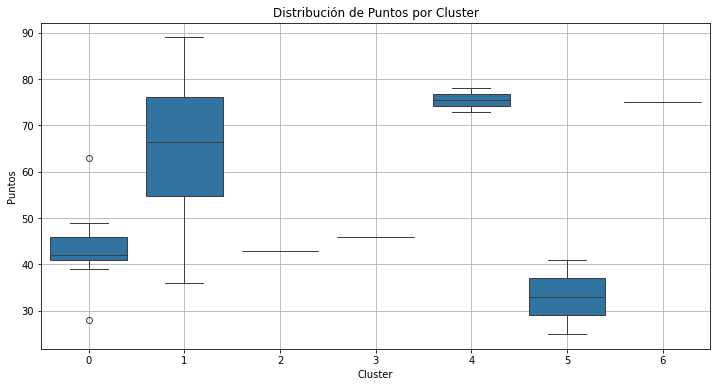

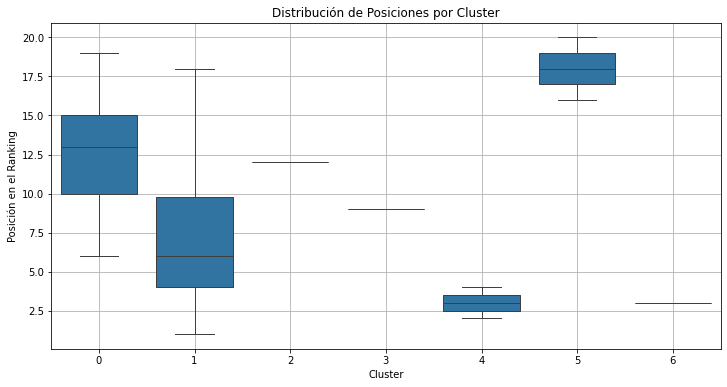

In [284]:
import matplotlib.pyplot as plt
import seaborn as sns

# Graficar la distribución de puntos por cluster
plt.figure(figsize=(12, 6))
sns.boxplot(x='Cluster', y='Puntos', data=merged_data)
plt.title('Distribución de Puntos por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Puntos')
plt.grid()
plt.show()

# Graficar la distribución de posiciones por cluster
plt.figure(figsize=(12, 6))
sns.boxplot(x='Cluster', y='Posicion', data=merged_data)
plt.title('Distribución de Posiciones por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Posición en el Ranking')
plt.grid()
plt.show()